# Recordatorio hacer normalización por desvios!!!

# Agregar tb feature de cluster por varias capas 2 10 50 100 500

In [7]:
import pandas as pd
import numpy as np
from dtaidistance import dtw
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import os
import gc
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

In [8]:
def percentage_safe(numerator: pd.Series, denominator: pd.Series, dtype='float32', fillna=None) -> pd.Series:
    """
    Calcula un porcentaje seguro como numerator / denominator.
    - Reemplaza divisiones por cero o NaN con NaN.
    - Opcionalmente convierte a float32.
    - Puede rellenar NaNs con `fillna`.
    """
    result = (numerator / denominator).mask((denominator == 0) | (denominator.isna()))
    if fillna is not None:
        result = result.fillna(fillna)
    return result.astype(dtype)

In [9]:
# Paths
BASE_DIR = '../'
PATH_TO_TRAIN = os.path.join(BASE_DIR, "Dataset/1_b_producto_autogluon.parquet")

In [10]:
df = pd.read_parquet(PATH_TO_TRAIN)

In [11]:
# --- 1. Preparación de Datos ---
# Agrupamos el DataFrame por cliente y producto y extraemos cada serie temporal.
# Las guardaremos en un diccionario para un acceso fácil.
# Es CRUCIAL que las series estén ordenadas por el campo de tiempo ('periodo').

#series_dict = {}
#for name, group in df.groupby(['product_id']):
#    if isinstance(name, tuple):  # 🔷 aquí está el fix
#        name = name[0]
#    group = group.sort_values('periodo')
#    values = group['producto_total_tn'].values  # 🚩 sin escalar
#    series_dict[name] = values
series_dict = {}
for name, group in df.groupby(['product_id']):
    # Ordenamos por si acaso.
    group = group.sort_values('periodo')
    
    # --- INICIO DE LA MODIFICACIÓN ---

    # 1. Obtenemos los valores de la serie temporal.
    values = group['producto_total_tn'].values
    
    # 2. Calculamos el desvío estándar (std) de ESTA serie específica.
    std_dev = values.std()
    
    # 3. Normalizamos dividiendo por el desvío estándar calculado.
    #    Mantenemos la comprobación para evitar divisiones por cero.
    if std_dev > 0:
        # Aquí simplemente dividimos.
        scaled_values = values / std_dev
    else:
        # Si el desvío es 0, todos los valores son iguales.
        scaled_values = np.zeros_like(values, dtype=float)
        
    series_dict[name] = scaled_values
    
    # --- FIN DE LA MODIFICACIÓN ---

print(f"--- Se extrajeron {len(series_dict)} series temporales ---")
series_list = list(series_dict.values())
series_ids = list(series_dict.keys())
print("IDs de las series:", series_ids)
print("\n")

#series_dict = {}
#for name, group in df.groupby([ 'product_id']):
#    # Ordenamos por si acaso, aunque en la simulación ya están ordenados.
#    group = group.sort_values('periodo')
    # Normalizamos cada serie (opcional pero muy recomendado)
    # Esto asegura que la forma de la serie, y no su escala, determine la similitud.
#    scaler = StandardScaler()
#    scaled_values = scaler.fit_transform(group['producto_total_tn'].values.reshape(-1, 1)).flatten()
#    series_dict[name] = scaled_values
    
#print(f"--- Se extrajeron {len(series_dict)} series temporales ---")
#series_list = list(series_dict.values())
#series_ids = list(series_dict.keys())
#print("IDs de las series:", series_ids)
#print("\n")


# --- 2. Cálculo de la Matriz de Distancias DTW ---
# Ahora calculamos la distancia DTW entre cada par de series.
# `dtaidistance` tiene una función optimizada para esto que es mucho más rápida
# que usar un doble bucle for.

# `dtw.distance_matrix` calcula la matriz de distancias completa.
# `use_c=True` activa la implementación rápida en C.
# `psi=1` añade una ventana de restricción (Sakoe-Chiba) para acelerar el cálculo,
# limitando cuánto puede "estirarse" el camino. Un valor de 1 significa que un punto
# solo puede mapearse al mismo punto o a su vecino inmediato. Aumenta este valor
# si esperas grandes desfases temporales.
distance_matrix = dtw.distance_matrix(series_list, use_c=True, psi=1)

# La matriz de distancias puede contener valores inf si las series son muy diferentes.
# Los reemplazamos por un valor alto para que el clustering funcione correctamente.
distance_matrix[np.isinf(distance_matrix)] = np.nanmax(distance_matrix[np.isfinite(distance_matrix)])

print("--- Matriz de Distancias DTW calculada (dimensiones: {}x{}) ---".format(distance_matrix.shape[0], distance_matrix.shape[1]))
# print(distance_matrix)
print("\n")

C:\Users\diana\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\diana\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


--- Se extrajeron 1233 series temporales ---
IDs de las series: [(20001,), (20002,), (20003,), (20004,), (20005,), (20006,), (20007,), (20008,), (20009,), (20010,), (20011,), (20012,), (20013,), (20014,), (20015,), (20016,), (20017,), (20018,), (20019,), (20020,), (20021,), (20022,), (20023,), (20024,), (20025,), (20026,), (20027,), (20028,), (20029,), (20030,), (20031,), (20032,), (20033,), (20034,), (20035,), (20036,), (20037,), (20038,), (20039,), (20040,), (20041,), (20042,), (20043,), (20044,), (20045,), (20046,), (20047,), (20048,), (20049,), (20050,), (20051,), (20052,), (20053,), (20054,), (20055,), (20056,), (20057,), (20058,), (20059,), (20060,), (20061,), (20062,), (20063,), (20064,), (20065,), (20066,), (20067,), (20068,), (20069,), (20070,), (20071,), (20072,), (20073,), (20074,), (20075,), (20076,), (20077,), (20078,), (20079,), (20080,), (20081,), (20082,), (20083,), (20084,), (20085,), (20086,), (20087,), (20088,), (20089,), (20090,), (20091,), (20092,), (20093,), (2009

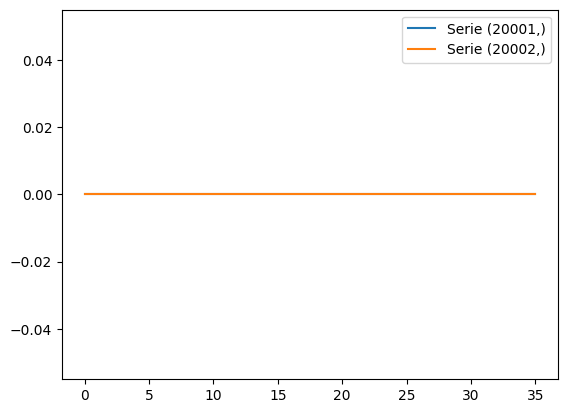

DTW entre ellas: 0.0


In [12]:
i, j = 0, 1  # índices de dos series distintas
plt.plot(series_list[i], label=f'Serie {series_ids[i]}')
plt.plot(series_list[j], label=f'Serie {series_ids[j]}')
plt.legend()
plt.show()
print(f"DTW entre ellas: {distance_matrix[i, j]}")


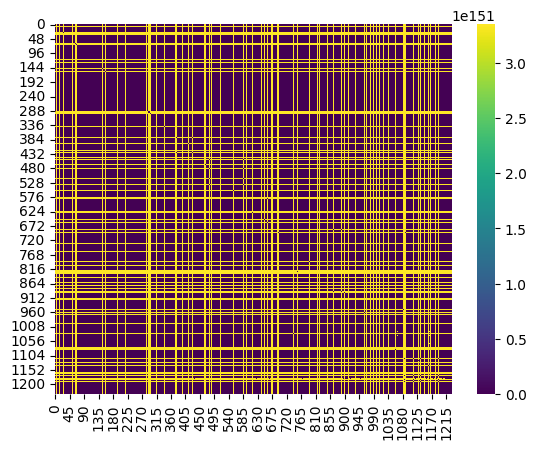

In [13]:
import seaborn as sns
sns.heatmap(distance_matrix, cmap='viridis')
plt.show()

In [14]:
np.min(distance_matrix[np.nonzero(distance_matrix)])

1.0519065574688522e-153

--- Generando y visualizando el dendrograma ---


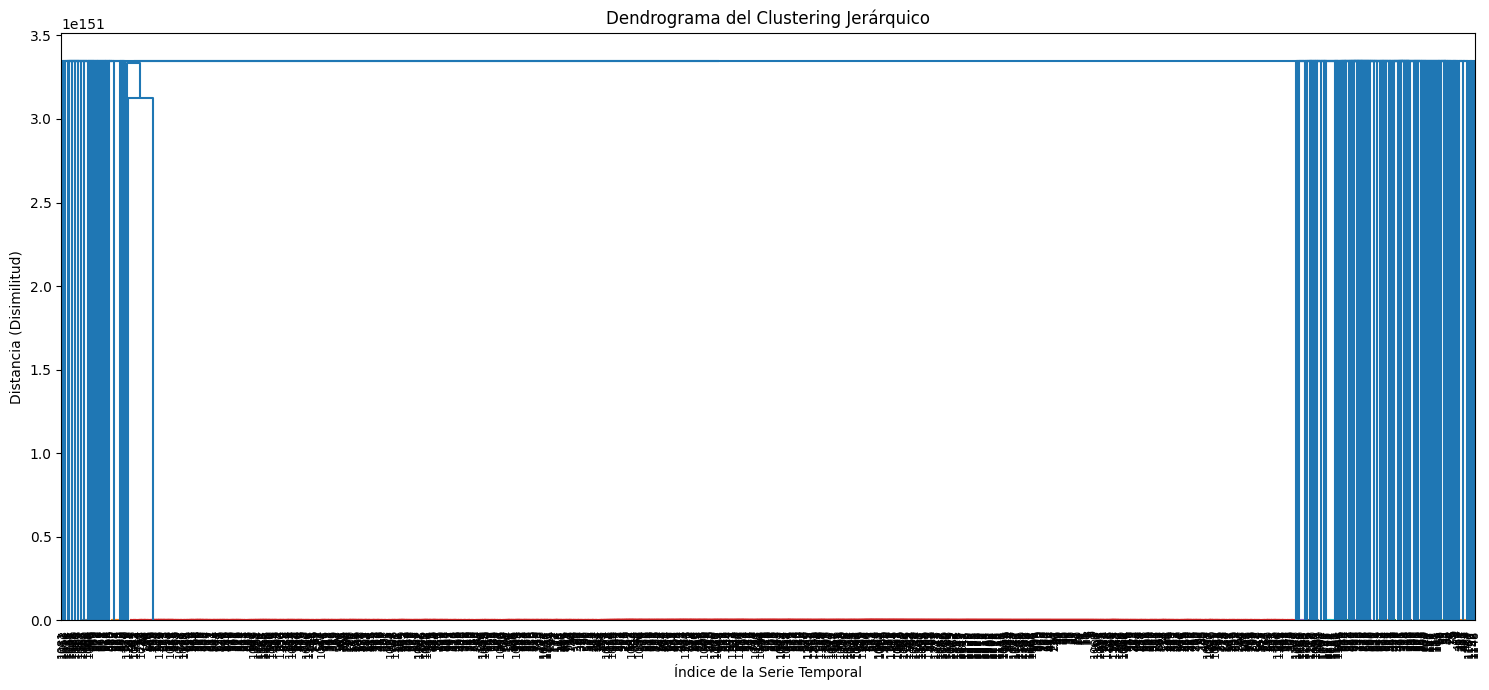


Se ha guardado el dendrograma en 'dendrograma_de_series.png'
>>> OBSERVA EL DENDROGRAMA Y DECIDE EL NÚMERO DE CLUSTERS. <<<
>>> LUEGO, ASIGNA ESE NÚMERO A LA VARIABLE 'n_clusters' MÁS ABAJO. <<<



In [15]:
# --- NUEVO PASO: 2. Visualización del Dendrograma para decidir N° de Clusters ---
print("--- Generando y visualizando el dendrograma ---")

# 1. Generamos la matriz de enlace (linkage matrix) usando el método 'average'.
# Es importante usar el mismo método ('average', 'complete', 'ward', etc.)
# que usarás después en tu modelo AgglomerativeClustering.
# La función linkage de SciPy trabaja sobre la matriz de distancias.

linked = linkage(squareform(distance_matrix), method='average')

# 2. Creamos la figura para el dendrograma
plt.figure(figsize=(15, 7))
plt.title('Dendrograma del Clustering Jerárquico')
plt.xlabel('Índice de la Serie Temporal')
plt.ylabel('Distancia (Disimilitud)')

# 3. Dibujamos el dendrograma
dendrogram(linked,
           orientation='top',
           # truncate_mode='lastp',  # Descomenta esto para mostrar solo los últimos 'p' clusters fusionados si tienes muchas series
           # p=12,
           leaf_rotation=90.,
           leaf_font_size=8.,
           show_contracted=True) # Para que se vea más limpio si hay muchas hojas

# Opcional: Añadir una línea de corte para guiar la decisión
# plt.axhline(y=1.5, color='r', linestyle='--') # Ajusta el valor de 'y' para cortar a diferentes alturas

plt.tight_layout()
plt.savefig("dendrograma_de_series.png")
plt.show()

print("\nSe ha guardado el dendrograma en 'dendrograma_de_series.png'")
print(">>> OBSERVA EL DENDROGRAMA Y DECIDE EL NÚMERO DE CLUSTERS. <<<")
print(">>> LUEGO, ASIGNA ESE NÚMERO A LA VARIABLE 'n_clusters' MÁS ABAJO. <<<\n")

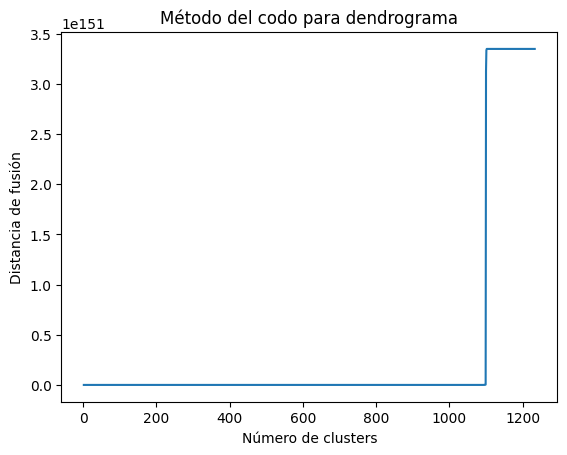

In [16]:
distances = linked[:, 2][::-1]
n_clusters = np.arange(len(distances)+1, 1, -1)

plt.plot(n_clusters, distances)
plt.xlabel("Número de clusters")
plt.ylabel("Distancia de fusión")
plt.title("Método del codo para dendrograma")
plt.show()

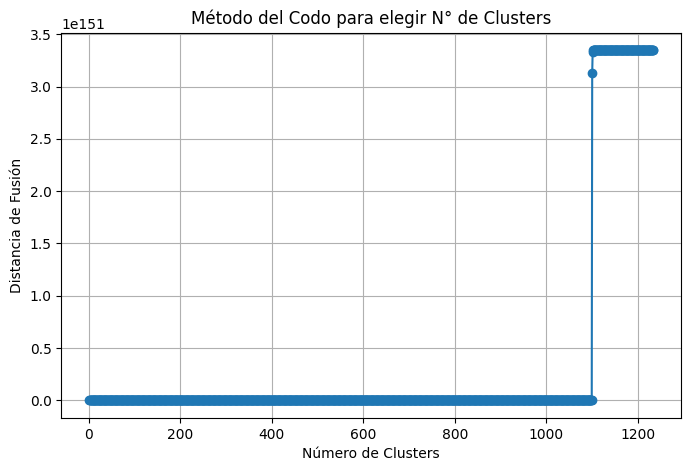

In [17]:

# ya calculaste `linked`
# linked = linkage(distance_matrix, method='average')

# n_samples originales
n_samples = distance_matrix.shape[0]

# obtenemos las distancias de las fusiones
distances = linked[:, 2]

# número de clusters resultantes en cada paso
n_clusters = np.arange(n_samples, 1, -1)  # de n_samples hasta 2

# distancias en orden inverso (para ver desde más clusters hasta menos)
distances_rev = distances[::-1]

# graficamos el codo
plt.figure(figsize=(8, 5))
plt.plot(n_clusters, distances_rev, marker='o')
plt.title('Método del Codo para elegir N° de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Distancia de Fusión')
plt.grid(True)
plt.show()


In [20]:
# --- 3. Clustering de las Series para Múltiples K ---
# En lugar de un solo número, definimos una lista de clusters a probar.
cluster_counts = [2, 3, 10, 50, 100,500]

print(f"Ejecutando el clustering para los siguientes números de clusters: {cluster_counts}\n")

# Creamos un DataFrame base que contendrá todos los resultados.
# La primera columna será el identificador de cada serie.
results_df = pd.DataFrame({'id': series_ids})

# Iteramos sobre cada número de clusters que queremos calcular.
for k in cluster_counts:
    print(f"... Calculando para k = {k} clusters")
    
    # 1. Configurar el modelo para el número actual de clusters (k)
    model = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='average')
    
    # 2. Entrenar el modelo y predecir los clusters
    clusters = model.fit_predict(distance_matrix)
    
    # 3. Añadir los resultados a nuestro DataFrame en una nueva columna
    #    El nombre de la columna será dinámico, ej: 'cluster_2', 'cluster_10', etc.
    column_name = f'cluster_{k}'
    results_df[column_name] = clusters

# --- 4. Análisis de Resultados ---
# Ahora el DataFrame 'results_df' contiene todas las asignaciones.
print("\n--- Resultados del Clustering Múltiple ---")
# Ordenamos por la primera asignación de cluster para una mejor visualización.
print(results_df.sort_values('cluster_2'))
print("\n")

Ejecutando el clustering para los siguientes números de clusters: [2, 3, 10, 50, 100, 500]

... Calculando para k = 2 clusters
... Calculando para k = 3 clusters
... Calculando para k = 10 clusters
... Calculando para k = 50 clusters
... Calculando para k = 100 clusters
... Calculando para k = 500 clusters

--- Resultados del Clustering Múltiple ---
            id  cluster_2  cluster_3  cluster_10  cluster_50  cluster_100  \
0     (20001,)          0          2           2           5            5   
794   (20804,)          0          2           2           5            5   
793   (20803,)          0          2           2           5            5   
792   (20802,)          0          2           2           5            5   
791   (20801,)          0          2           2           5            5   
...        ...        ...        ...         ...         ...          ...   
997   (21024,)          1          1           3          24           24   
996   (21023,)          1       

In [21]:
results_df.head()

,id,cluster_2,cluster_3,cluster_10,cluster_50,cluster_100,cluster_500
0,"(20001,)",0,2,2,5,5,2
1,"(20002,)",0,2,2,5,5,2
2,"(20003,)",0,0,1,33,67,271
3,"(20004,)",0,2,2,5,5,2
4,"(20005,)",0,0,1,30,61,495


In [22]:
# Extraer el primer elemento de la tupla
results_df['id'] = results_df['id'].apply(lambda x: x[0] if isinstance(x, (list, tuple)) else x)

# Ahora ya es una serie de enteros o strings, puedes convertirla si quieres
results_df['id'] = results_df['id'].astype(int)

# Realizas el merge
df = df.merge(
    results_df.rename(columns={'id': 'product_id'}),
    on='product_id',
    how='left'
)


In [27]:
df.sample(200)

,periodo,product_id,producto_total_tn,avg_tn,std_tn,clientes_distintos,cust_request_qty,cust_request_tn,inicio_vida_p,fin_vida_p,...,tn_pred_auto_delta_a_tn,ratio_tn_pred_auto_delta_a_tn,ratio_tn_pred_a_tn,ultima_tn,cluster_2,cluster_3,cluster_10,cluster_50,cluster_100,cluster_500
27041,201911,20972,3.785156,0.006359,0.028946,595,274,4.031250,201910,201912,...,NaN,NaN,NaN,2.976562,0,2,2,5,5,2
11424,201812,20349,10.773438,0.019302,0.104858,558,359,10.773438,201701,201912,...,2.144531,0.199097,1.199219,17.468750,0,2,2,5,5,440
27686,201709,21002,2.146484,0.004089,0.025681,525,140,2.146484,201701,201805,...,-0.514648,-0.239868,0.760254,0.316650,1,1,3,0,62,126
18777,201710,20612,4.625000,0.008812,0.029984,525,213,4.625000,201701,201912,...,0.027603,0.005970,1.005859,4.183594,0,2,2,5,5,193
267,201804,20008,691.500000,1.297852,5.687500,533,465,720.500000,201701,201912,...,-160.625000,-0.232300,0.767578,195.375000,0,2,2,5,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737,201812,20108,68.687500,0.123108,0.471680,558,267,72.812500,201701,201912,...,13.789062,0.200806,1.201172,58.343750,0,2,2,5,5,23
9278,201701,20284,28.953125,0.066833,0.294922,433,525,28.953125,201701,201912,...,NaN,NaN,NaN,11.796875,0,2,2,5,5,257
22680,201812,20776,2.419922,0.004337,0.026779,558,160,2.419922,201701,201907,...,-0.150269,-0.062103,0.937988,0.638184,0,2,2,5,5,97
21487,201803,20722,5.937500,0.011162,0.043335,532,216,5.937500,201701,201905,...,0.624512,0.105164,1.105469,0.893555,0,0,1,2,3,464


# Export

In [28]:
df.to_parquet('1_c_producto.parquet', index=False)

In [30]:
#df_train = df[~df['periodo'].isin([201911, 201912])]
df_train = df.query("periodo != 201911 and periodo != 201912")

df_train.to_parquet('1_c_producto_train.parquet', index=False)
print(f"DataFrame de entrenamiento guardado en 'train.parquet' con {len(df_train)} filas.")

# --- 3. Preparar y guardar el DataFrame de predicción en Parquet ---
# Seleccionamos los periodos 201911 y 201912 para el conjunto de predicción.
# Eliminamos la columna 'clase' ya que no será necesaria para la predicción.
# Finalmente, guardamos este DataFrame en un archivo Parquet.
df_predecir = df[df['periodo'].isin([201911, 201912])].copy() # Usar .copy() para evitar SettingWithCopyWarning
df_predecir.drop(columns=['clase_producto'], inplace=True)
df_predecir.to_parquet('1_c_producto_predecir.parquet', index=False)
print(f"DataFrame para predicción guardado en 'predecir.parquet' con {len(df_predecir)} filas.")

DataFrame de entrenamiento guardado en 'train.parquet' con 29652 filas.
DataFrame para predicción guardado en 'predecir.parquet' con 1870 filas.
